In [32]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import pytz
from datetime import datetime, timedelta
from watttime import WattTimeForecast, WattTimeHistorical

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import watttime.shared_anniez.alg.optCharger as optC
import watttime.shared_anniez.alg.moer as Moer

region = "ERCOT_AUSTIN"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
key = '20240715_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

# Synthetic User Data

In [33]:
synth_data = generated_data.copy(deep=True)

synth_data["plug_in_time"] = pd.to_datetime(synth_data["plug_in_time"])
synth_data["unplug_time"] = pd.to_datetime(synth_data["unplug_time"])

In [34]:
# one user - 10 sessions - Feb 2024
synth_data = synth_data.sample(100)

## API Data

In [35]:
synth_data['moer_data'] = synth_data.apply(
    lambda x: efu.get_historical_fcst_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

synth_data['moer_data_actual'] = synth_data.apply(
    lambda x: efu.get_historical_actual_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

## MOER - No Optimization - Actual Emissions

In [36]:
synth_data['charger_baseline_actual'] = synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = True
        ), 
        axis = 1
        )

synth_data['baseline_charging_schedule'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['baseline_actual_emissions'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_total_cost()
    )

In [39]:
import seaborn as sns

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

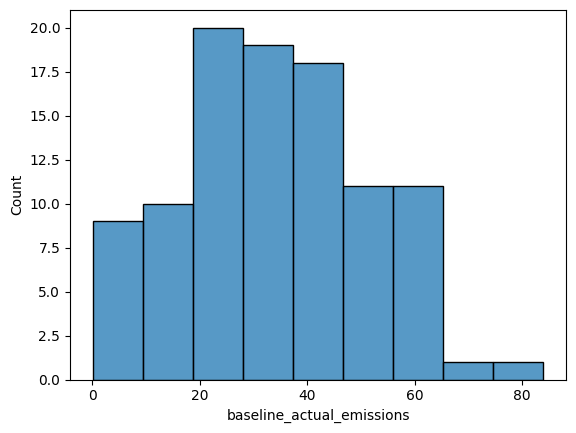

In [40]:
sns.histplot(synth_data['baseline_actual_emissions'])

## MOER - Simple Optimization - Forecast Emissions

In [41]:
synth_data['charger_simple_forecast']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data,
        asap = False
        ), 
        axis = 1
        )

synth_data['simple_charing_schedule'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['simple_estimated_emissions'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_total_cost()
    )

In [42]:
def get_total_emission(moer, schedule): 
    x = np.array(schedule).flatten()
    return np.dot(moer[:x.shape[0]], x)

In [44]:
synth_data["simple_actual_emissions"] = synth_data.apply(
    lambda x: get_total_emission(
        x.moer_data_actual['value'],
        x.simple_charing_schedule,
    ),
    axis = 1
)

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

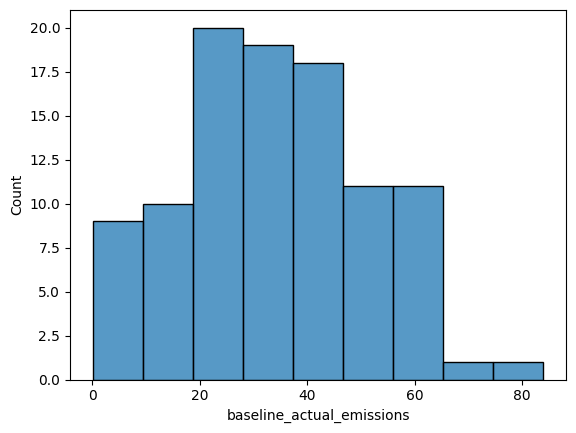

In [46]:
sns.histplot(synth_data["baseline_actual_emissions"])

<Axes: xlabel='simple_actual_emissions', ylabel='Count'>

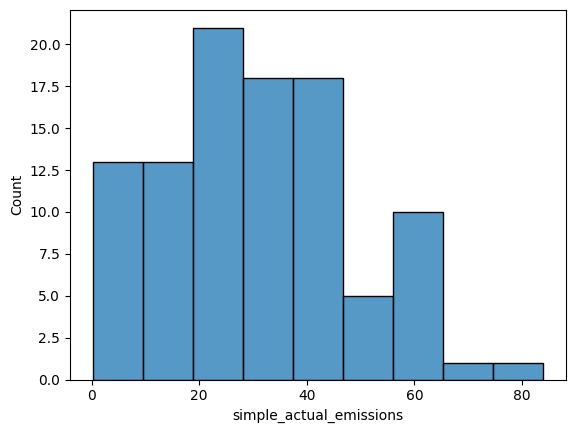

In [45]:
sns.histplot(synth_data["simple_actual_emissions"])

In [47]:
synth_data["simple_optimization_difference"] = synth_data["simple_actual_emissions"] - synth_data["baseline_actual_emissions"]

In [53]:
synth_data["success_rate"] = synth_data["simple_optimization_difference"] < 0

In [54]:
synth_data["success_rate"].value_counts()

success_rate
False    67
True     33
Name: count, dtype: int64